In [2]:
import pandas as pd 
import numpy as np

# Sklearn
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Statistics
import scipy.stats as stats

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning
from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings

In [6]:
train = pd.read_csv('data/train.csv', index_col='id')
test = pd.read_csv('data/test.csv', index_col='id')
horse = pd.read_csv('data/horse.csv')
sample_submission = pd.read_csv('data/sample_submission.csv', index_col = 'id')

In [19]:
train = pd.concat([train, horse], ignore_index=True).drop_duplicates()

In [8]:
train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1531 entries, 0 to 1533
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1531 non-null   object 
 1   age                    1531 non-null   object 
 2   hospital_number        1531 non-null   int64  
 3   rectal_temp            1471 non-null   float64
 4   pulse                  1507 non-null   float64
 5   respiratory_rate       1473 non-null   float64
 6   temp_of_extremities    1436 non-null   object 
 7   peripheral_pulse       1402 non-null   object 
 8   mucous_membrane        1463 non-null   object 
 9   capillary_refill_time  1493 non-null   object 
 10  pain                   1432 non-null   object 
 11  peristalsis            1467 non-null   object 
 12  abdominal_distention   1452 non-null   object 
 13  nasogastric_tube       1348 non-null   object 
 14  nasogastric_reflux     1404 non-null   object 
 15  nasogastr

Check missing values

In [12]:
train.isna().sum().sort_values(ascending=False)

abdomen                  329
rectal_exam_feces        292
nasogastric_reflux_ph    246
abdomo_appearance        213
abdomo_protein           198
nasogastric_tube         183
peripheral_pulse         129
nasogastric_reflux       127
pain                      99
temp_of_extremities       95
abdominal_distention      79
mucous_membrane           68
peristalsis               64
rectal_temp               60
respiratory_rate          58
capillary_refill_time     38
total_protein             33
packed_cell_volume        29
pulse                     24
lesion_1                   0
lesion_3                   0
cp_data                    0
lesion_2                   0
surgery                    0
surgical_lesion            0
age                        0
hospital_number            0
outcome                    0
dtype: int64

Check for duplicate values

In [13]:
train.duplicated().sum()

0

In [14]:
train.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1.531000e+03,1471.000000,1507.000000,1473.000000,1285.000000,1502.000000,1498.000000,1333.000000,1531.000000,1531.000000,1531.000000
mean,9.782395e+05,38.196941,78.145985,30.105906,4.396109,49.017976,21.883044,3.269017,3801.345526,29.467015,4.328543
std,1.389757e+06,0.779873,29.077196,16.597691,1.940040,10.596155,26.799768,1.617140,5434.895232,337.075782,97.720282
min,5.184760e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.300000,0.100000,0.000000,0.000000,0.000000
25%,5.288040e+05,37.800000,52.000000,18.000000,2.000000,42.000000,6.600000,2.000000,2124.000000,0.000000,0.000000
50%,5.298270e+05,38.200000,72.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,5.341970e+05,38.600000,96.000000,36.000000,6.200000,55.000000,13.000000,4.300000,3205.000000,0.000000,0.000000
max,5.305629e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,7111.000000,2209.000000


In [15]:
# Identify numerical and categorical features
numeric_features = train.select_dtypes(exclude='object').columns.tolist()
categorical_features = train.select_dtypes(include='object').columns.tolist()

# Print the number and names of each type of feature
print(f"We have {len(numeric_features)} numerical features: {', '.join(numeric_features)}")
print(f"We have {len(categorical_features)} categorical features: {', '.join(categorical_features)}")

We have 11 numerical features: hospital_number, rectal_temp, pulse, respiratory_rate, nasogastric_reflux_ph, packed_cell_volume, total_protein, abdomo_protein, lesion_1, lesion_2, lesion_3
We have 17 categorical features: surgery, age, temp_of_extremities, peripheral_pulse, mucous_membrane, capillary_refill_time, pain, peristalsis, abdominal_distention, nasogastric_tube, nasogastric_reflux, rectal_exam_feces, abdomen, abdomo_appearance, surgical_lesion, cp_data, outcome


In [16]:
for column in categorical_features:
  print('Categories in column',column, 'are', set(train[column]))

Categories in column surgery are {'no', 'yes'}
Categories in column age are {'adult', 'young'}
Categories in column temp_of_extremities are {nan, 'cold', 'cool', 'normal', 'warm'}
Categories in column peripheral_pulse are {nan, 'reduced', 'increased', 'normal', 'absent'}
Categories in column mucous_membrane are {nan, 'pale_pink', 'normal_pink', 'bright_red', 'bright_pink', 'dark_cyanotic', 'pale_cyanotic'}
Categories in column capillary_refill_time are {nan, 'more_3_sec', '3', 'less_3_sec'}
Categories in column pain are {nan, 'depressed', 'alert', 'extreme_pain', 'slight', 'severe_pain', 'mild_pain'}
Categories in column peristalsis are {nan, 'normal', 'hypermotile', 'absent', 'distend_small', 'hypomotile'}
Categories in column abdominal_distention are {nan, 'severe', 'none', 'slight', 'moderate'}
Categories in column nasogastric_tube are {'slight', nan, 'none', 'significant'}
Categories in column nasogastric_reflux are {nan, 'none', 'more_1_liter', 'slight', 'less_1_liter'}
Categories

C:\Users\neete\AppData\Local\Temp\ipykernel_16348\3523323043.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=combined_data, x=col, hue='Source', palette=['#456cf0', '#ed7647'], linewidth=2.1, ax=axes[i, 0])


Text(0.5, 1.02, 'Numerical features -> Distribution analysis')

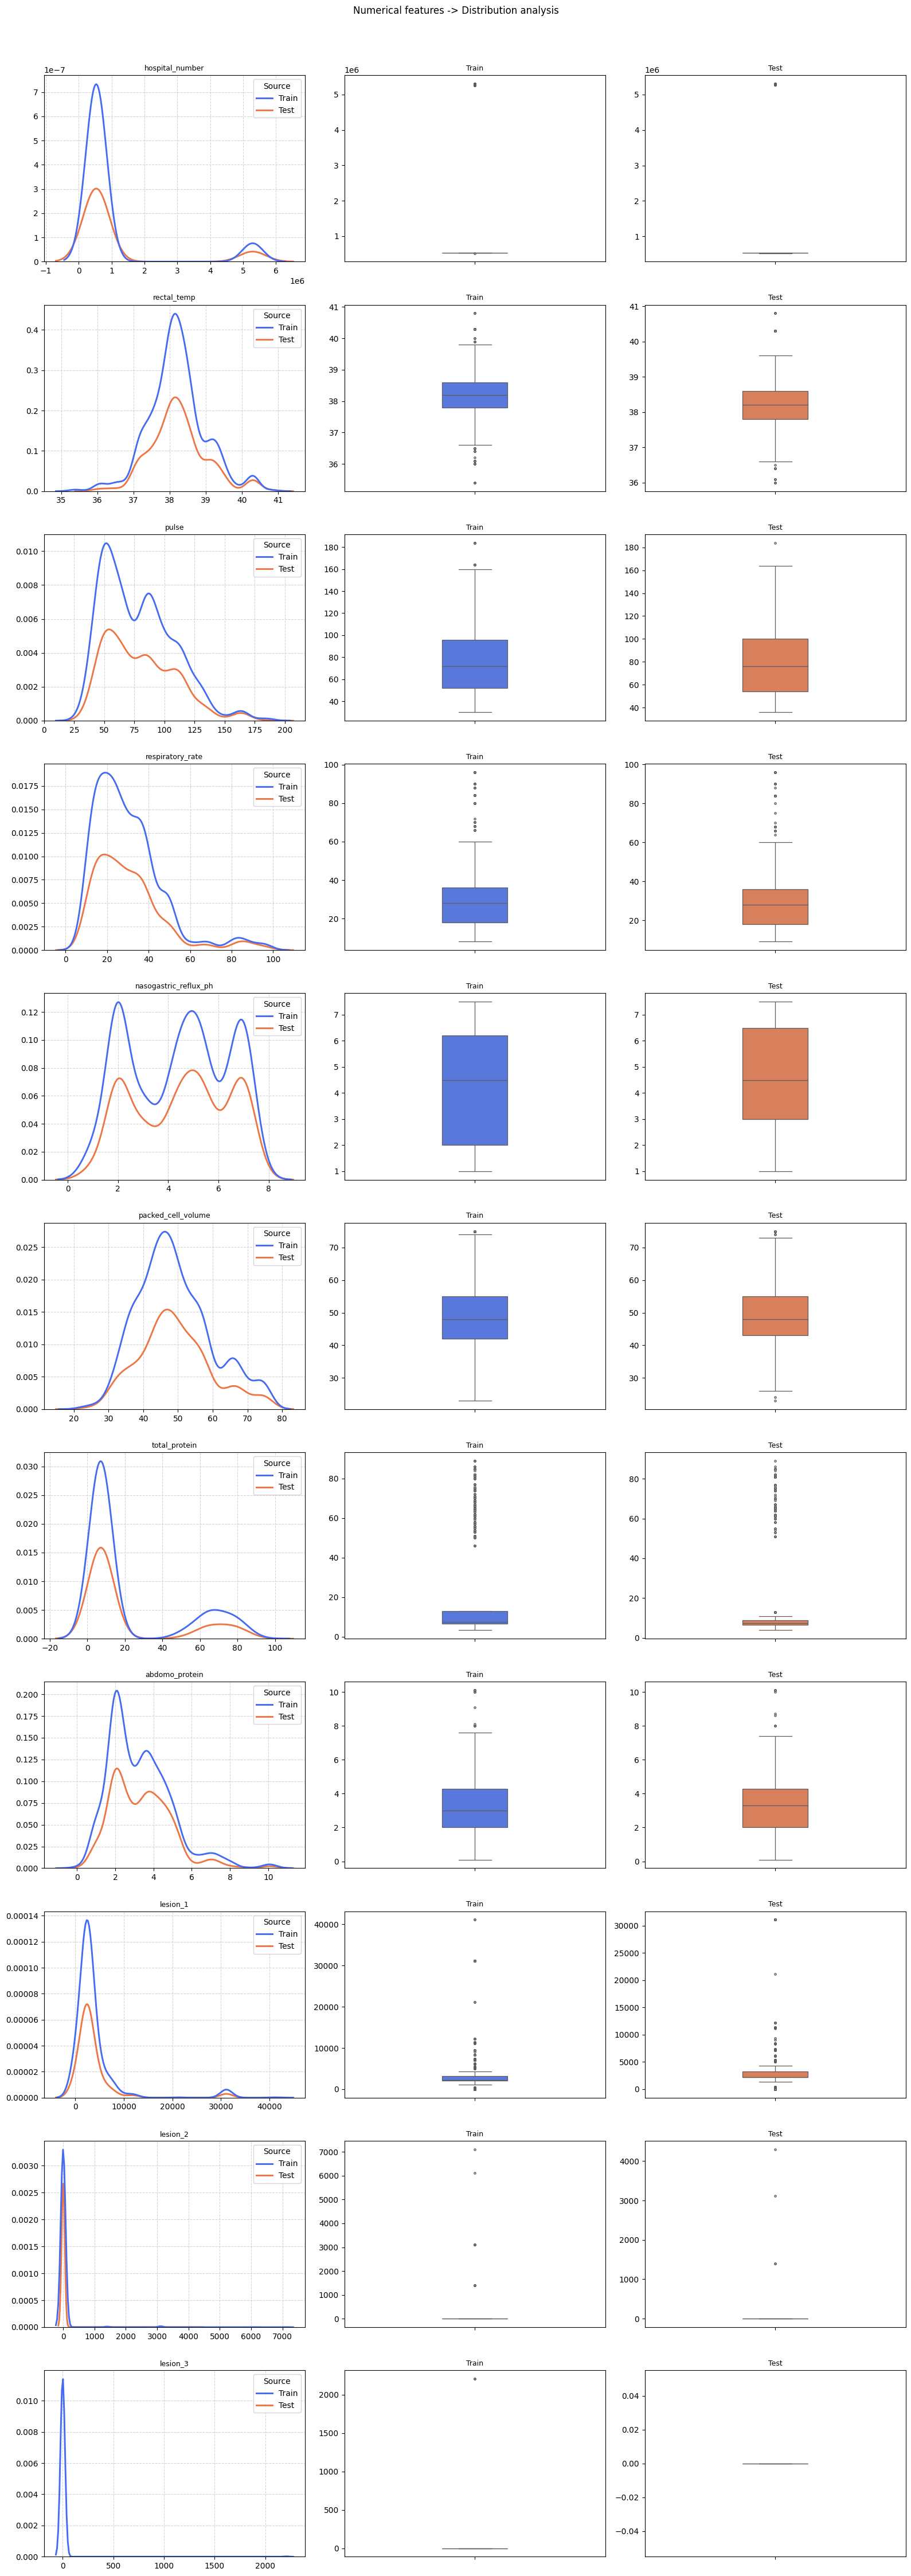

In [17]:
# Select numeric features
numeric_features = train.select_dtypes(include=['int64', 'float64'])

# Combine train and test datasets with a 'Source' column
train['Source'] = 'Train'
test['Source'] = 'Test'
combined_data = pd.concat([train, test], ignore_index=True)

# Set up the subplots
num_features = numeric_features.columns
num_rows = len(num_features)
num_cols = 3  # 3 columns for KDE, Train Boxplot, and Test Boxplot

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

# Loop through numeric features
for i, col in enumerate(num_features):
    # KDE plot
    sns.kdeplot(data=combined_data, x=col, hue='Source', palette=['#456cf0', '#ed7647'], linewidth=2.1, ax=axes[i, 0])
    axes[i, 0].set_title(f"{col}", fontsize=9)
    axes[i, 0].grid(visible=True, which='both', linestyle='--', color='lightgrey', linewidth=0.75)
    axes[i, 0].set(xlabel='', ylabel='')

    # Train Boxplot
    sns.boxplot(data=combined_data[combined_data['Source'] == 'Train'], y=col, width=0.25, linewidth=0.90, fliersize=2.25, color='#456cf0', ax=axes[i, 1])
    axes[i, 1].set(xlabel='', ylabel='')
    axes[i, 1].set_title("Train", fontsize=9)

    # Test Boxplot
    sns.boxplot(data=combined_data[combined_data['Source'] == 'Test'], y=col, width=0.25, linewidth=0.90, fliersize=2.25, color='#ed7647', ax=axes[i, 2])
    axes[i, 2].set(xlabel='', ylabel='')
    axes[i, 2].set_title("Test", fontsize=9)

# Remove the 'Source' column added earlier
train.drop(columns=['Source'], inplace=True)
test.drop(columns=['Source'], inplace=True)

# Adjust subplot spacing and display the plot
plt.tight_layout()
plt.suptitle(f'Numerical features -> Distribution analysis', fontsize=12, y=1.02)  # Increased y value


The distribution of test and train features are very similar and there doesn't seem to be any data drift



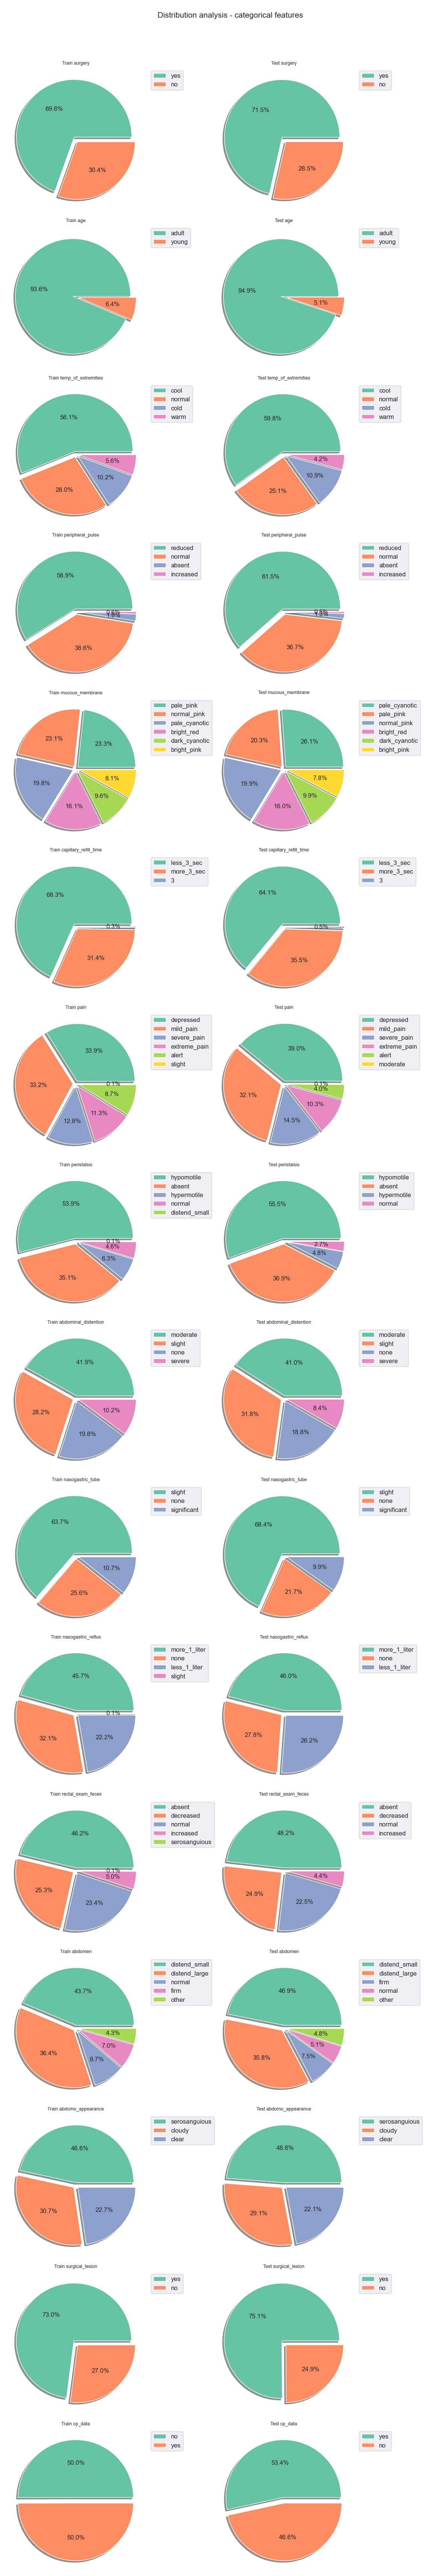

In [20]:
# Set color palette
sns.set_palette('Set2')

# Select categorical features
num = train.drop(columns='outcome').select_dtypes(include=['object']).columns

# Combine train and test datasets with a 'Source' column
df = pd.concat([train[num].assign(Source='train'),
                test[num].assign(Source='test')],
               axis=0, ignore_index=True)

# Set up the subplots
fig, axes = plt.subplots(len(num), 2, figsize=(12, len(num) * 4.2))

# Loop through categorical features
for i, col in enumerate(num):
    train_dist = df.loc[df.Source == 'train', [col]].value_counts()
    test_dist = df.loc[df.Source == 'test', [col]].value_counts()

    ax = axes[i, 0]
    ax.pie(train_dist, shadow=True, explode=[.05] * len(train_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in train_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel='', ylabel='')
    ax.set_title(f'Train {col}', fontsize=9)

    ax = axes[i, 1]
    ax.pie(test_dist, shadow=True, explode=[.05] * len(test_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in test_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel='', ylabel='')
    ax.set_title(f'Test {col}', fontsize=9)

# Adjust subplot spacing and display the plot
plt.tight_layout()
plt.suptitle(f"\nDistribution analysis - categorical features", fontsize=15, y=1.02, x=0.57)  # Increased y value
plt.show()


The distribution of test and train features are very similar and there doesn't seem to be any data drift for CATEGORICAL features


Check for Data distribution in 'Outcome' column

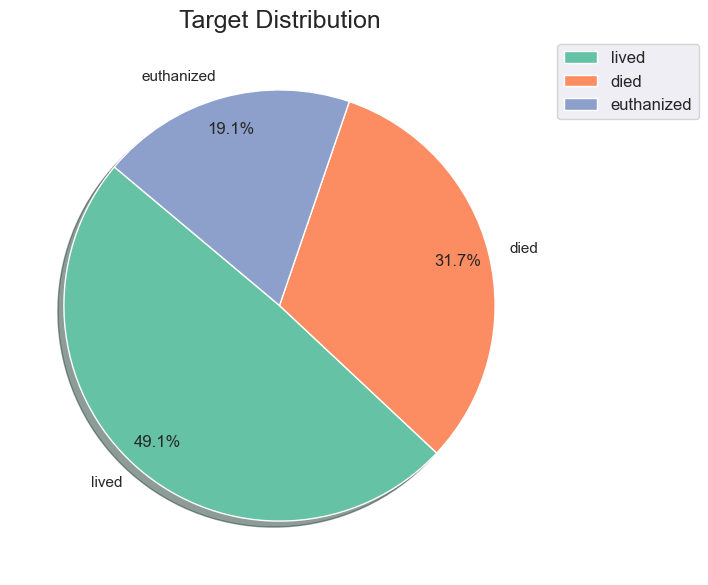

In [21]:
target_dist = train['outcome'].value_counts()

# Set the color palette
sns.set_palette('Set2')

# Create a pie chart
plt.figure(figsize=(7, 7))
plt.pie(target_dist, labels=target_dist.index, autopct='%.1f%%', shadow=True, startangle=140, pctdistance=0.85)

# Title and legend
plt.title('Target Distribution', fontsize=18)
plt.legend(target_dist.index, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.show()

<Axes: >

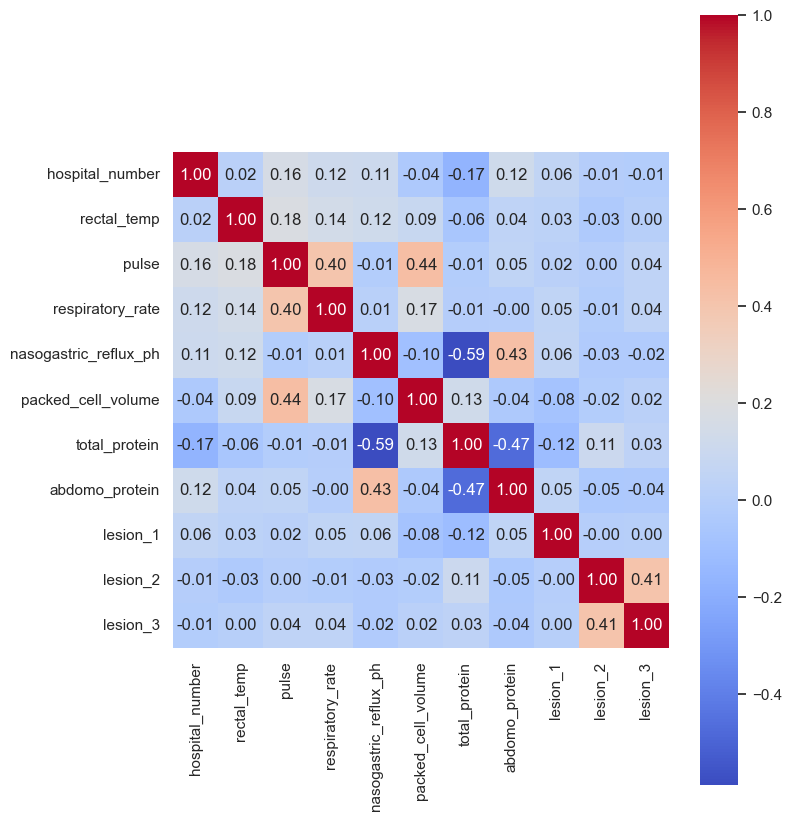

In [23]:
plt.figure(figsize=(8, 10))
sns.set(font_scale=1)
numeric_columns = train.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_columns.corr()
#corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

In [25]:
import pandas as pd
from scipy.stats import chi2_contingency


# Create a contingency table
contingency_table = pd.crosstab(train['surgery'], train['outcome'])

# Perform the Chi-Square test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Display the contingency table
print("Contingency Table:")
print(contingency_table)

# Display the results of the Chi-Square test
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
print("\nInterpretation:")
if p < alpha:
    print("There is a statistically significant relationship between 'surgery' and 'outcome'.")
else:
    print("There is no statistically significant relationship between 'surgery' and 'outcome'.")


Contingency Table:
outcome  died  euthanized  lived
surgery                         
no         93          95    278
yes       393         198    474

Chi-Square Test Results:
Chi-Square Statistic: 45.01128663430207
P-value: 1.682376896403913e-10

Interpretation:
There is a statistically significant relationship between 'surgery' and 'outcome'.


<Figure size 1200x600 with 0 Axes>

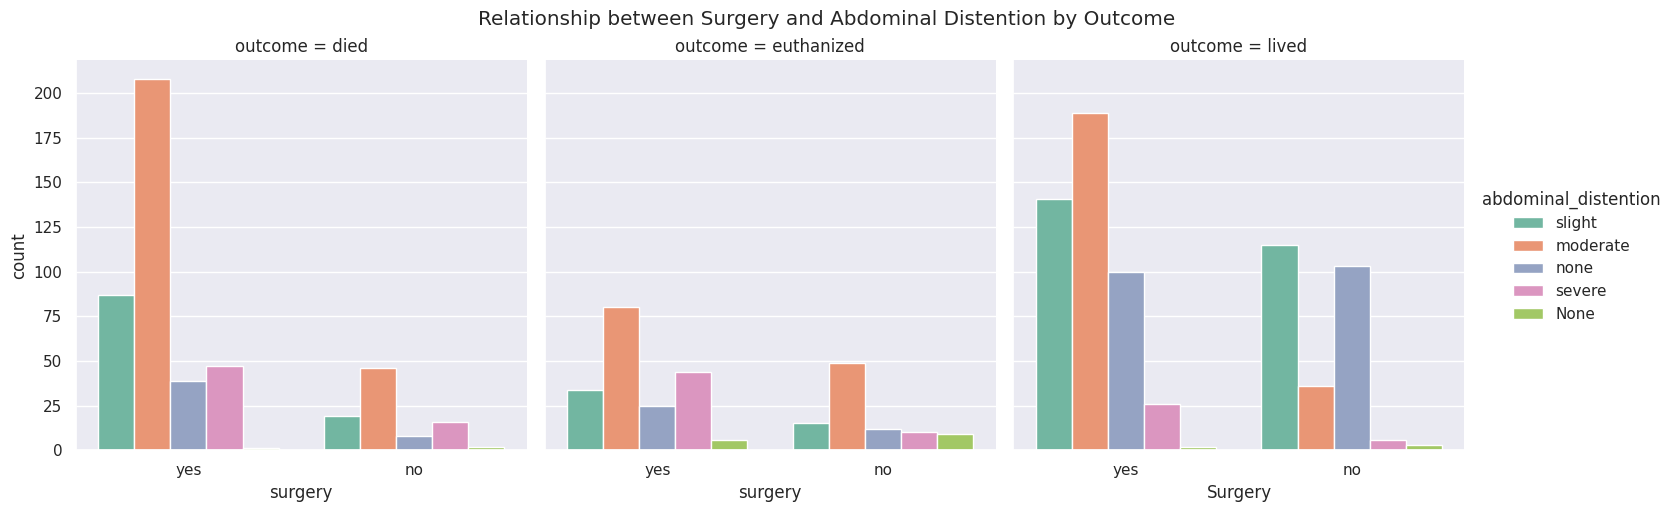

In [20]:

# Create a categorical plot (catplot)
plt.figure(figsize=(12, 6))
sns.catplot(data=train, x="surgery", hue="abdominal_distention", col="outcome", kind="count", palette="Set2")

# Set labels and title
plt.xlabel("Surgery")
plt.ylabel("Count")
plt.suptitle("Relationship between Surgery and Abdominal Distention by Outcome", y=1.02)

# Show the plot
plt.show()


In [26]:
train['abdominal_distention'].value_counts()

abdominal_distention
moderate    608
slight      409
none        287
severe      148
Name: count, dtype: int64

In [27]:
# Adding 'lesion_2' and 'lesion_3' columns as these are also categorical in nature
categorical_features += ['lesion_2', 'lesion_3']

# Create a list to store the dependent features
dependent_features = []

# Iterate through each categorical feature
for feature in categorical_features:
    # Create a contingency table
    contingency_table = pd.crosstab(train[feature], train['outcome'])

    # Perform the Chi-Square test
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)

    # Check if the p-value is greater than or equal to the threshold
    if p >= 0.05:
        dependent_features.append(feature)

print('These columns are to be dropped ', dependent_features)

These columns are to be dropped  ['lesion_3']


In [28]:
train.drop('lesion_3', axis=1, inplace=True)

In [29]:
X = train.drop(columns='outcome')
y = train[['outcome']]

In [30]:
X.isna().sum().sort_values(ascending=False)

abdomen                  329
rectal_exam_feces        292
nasogastric_reflux_ph    246
abdomo_appearance        213
abdomo_protein           198
nasogastric_tube         183
peripheral_pulse         129
nasogastric_reflux       127
pain                      99
temp_of_extremities       95
abdominal_distention      79
mucous_membrane           68
peristalsis               64
rectal_temp               60
respiratory_rate          58
capillary_refill_time     38
total_protein             33
packed_cell_volume        29
pulse                     24
surgical_lesion            0
lesion_1                   0
lesion_2                   0
surgery                    0
age                        0
hospital_number            0
cp_data                    0
dtype: int64

In [33]:

numeric_features = X.select_dtypes(exclude='object').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

numerical_pipeline = Pipeline([
    ('imputer', IterativeImputer(max_iter=50, random_state=0)),  
    ('quantile_transform', QuantileTransformer(output_distribution='normal', random_state=42)),
    ('standard_scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
      ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10))
])


# Define the ColumnTransformer
preprocessor  = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder='passthrough', 
    verbose_feature_names_out=False  
)


In [34]:
X = preprocessor.fit_transform(X)
y = y.applymap({'died': 0, 'euthanized': 1, 'lived': 2}.get)

In [35]:
X = pd.DataFrame(data=X, columns=preprocessor.get_feature_names_out(), index=train.index)
X.head()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,...,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
0,0.059599,-0.132314,1.715481,-0.201903,0.700182,0.621960,0.465342,0.079349,0.215733,-0.099107,...,1.0,0.0,3.0,2.0,0.0,1.0,1.0,2.0,1.0,0.0
1,0.459799,-0.981139,0.399619,-1.419419,-0.759118,-1.494518,0.933896,-0.810820,0.086590,-0.099107,...,3.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0
2,-0.008595,0.265026,1.310674,0.018783,-0.247790,-0.987952,-0.938531,0.079349,0.765242,-0.099107,...,2.0,3.0,0.0,2.0,2.0,0.0,0.0,2.0,1.0,0.0
3,1.305876,-1.580544,-0.031400,0.171053,-0.759118,0.358703,-0.398358,0.563787,0.086590,-0.099107,...,3.0,3.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2.402386,-0.359448,-0.717147,1.092158,1.029428,-0.126795,-0.187358,-0.267719,-2.709182,-0.099107,...,0.0,3.0,1.0,2.0,0.0,3.0,3.0,1.0,0.0,1.0


There are no missing values now

In [36]:
X.isna().sum()

hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
nasogastric_reflux_ph    0
packed_cell_volume       0
total_protein            0
abdomo_protein           0
lesion_1                 0
lesion_2                 0
surgery                  0
age                      0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
rectal_exam_feces        0
abdomen                  0
abdomo_appearance        0
surgical_lesion          0
cp_data                  0
dtype: int64

In [37]:
X.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,...,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
count,1.531000e+03,1.531000e+03,1.531000e+03,1.531000e+03,1.531000e+03,1.531000e+03,1.531000e+03,1.531000e+03,1.531000e+03,1.531000e+03,...,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000
mean,-4.641037e-18,-3.596804e-17,3.248726e-17,2.320518e-18,4.641037e-18,1.856415e-17,-3.364752e-17,4.350972e-17,-2.320518e-18,-5.894117e-16,...,2.005879,1.973873,1.182234,1.455258,1.091444,0.856956,1.007185,1.344873,0.729589,0.499673
std,1.000327e+00,1.000327e+00,1.000327e+00,1.000327e+00,1.000327e+00,1.000327e+00,1.000327e+00,1.000327e+00,1.000327e+00,1.000327e+00,...,1.226331,1.443252,1.257697,0.836146,0.701631,1.161381,0.958253,0.785451,0.444318,0.500163
min,-5.135740e+00,-5.017873e+00,-4.969136e+00,-4.831078e+00,-3.749500e+00,-4.253677e+00,-5.067219e+00,-5.051251e+00,-2.709182e+00,-9.910687e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.669482e-01,-6.313112e-01,-7.171468e-01,-6.684758e-01,-4.519672e-01,-5.863544e-01,-6.465576e-01,-8.108204e-01,-2.222461e-01,-9.910687e-02,...,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,-1.159513e-03,6.805549e-02,-3.140026e-02,1.878280e-02,-8.369686e-03,-1.105112e-02,-1.403032e-02,-1.424882e-02,2.157327e-01,-9.910687e-02,...,2.000000,3.000000,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000
75%,6.639978e-01,5.818860e-01,6.023215e-01,5.134770e-01,5.051711e-01,4.889107e-01,6.525415e-01,6.403030e-01,5.137575e-01,-9.910687e-02,...,3.000000,3.000000,3.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
max,5.135899e+00,5.023052e+00,4.963867e+00,4.794302e+00,3.827904e+00,4.152438e+00,5.058706e+00,5.024889e+00,3.083316e+00,1.301798e+01,...,5.000000,4.000000,3.000000,2.000000,3.000000,4.000000,4.000000,2.000000,1.000000,1.000000


Model Training

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((1224, 26), (307, 26))

In [40]:
def evaluate_model(true, predicted):
    accuracy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted, average='weighted')  # Use weighted average for multiclass
    recall = recall_score(true, predicted, average='weighted')  # Use weighted average for multiclass
    f1 = f1_score(true, predicted, average='weighted')  # Use weighted average for multiclass
    return accuracy, precision, recall, f1


In [41]:
models = {
    "XGBoost Classifier": XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Random Forest Classifier": RandomForestClassifier()
}

cv_scores = {}

# Perform cross-validation for each model
for model_name, model in models.items():
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    # Store the scores in the dictionary
    cv_scores[model_name] = scores

    print(model_name)
    print("Cross-Validation Accuracy Scores:", scores)
    print("Mean Accuracy:", scores.mean())
    print("Std Deviation of Accuracy:", scores.std())
    print("=" * 35)


for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    accuracy_train, precision_train, recall_train, f1_train = evaluate_model(y_train, y_train_pred)
    accuracy_test, precision_test, recall_test, f1_test = evaluate_model(y_test, y_test_pred)

    print('*' * 35)
    print(model_name)
    print('*' * 35)
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(accuracy_train))
    print("- Precision: {:.4f}".format(precision_train))
    print("- Recall: {:.4f}".format(recall_train))
    print("- F1-Score: {:.4f}".format(f1_train))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(accuracy_test))
    print("- Precision: {:.4f}".format(precision_test))
    print("- Recall: {:.4f}".format(recall_test))
    print("- F1-Score: {:.4f}".format(f1_test))
    print('=' * 35)
    print('\n')

XGBoost Classifier
Cross-Validation Accuracy Scores: [0.70612245 0.71020408 0.71428571 0.74693878 0.71311475]
Mean Accuracy: 0.7181331549013048
Std Deviation of Accuracy: 0.014675681818647097


c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\sklearn

AdaBoost Classifier
Cross-Validation Accuracy Scores: [0.67755102 0.68571429 0.66938776 0.73061224 0.67213115]
Mean Accuracy: 0.6870792907326865
Std Deviation of Accuracy: 0.022468674595014452


c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\s

Random Forest Classifier
Cross-Validation Accuracy Scores: [0.68163265 0.70204082 0.68163265 0.73469388 0.68852459]
Mean Accuracy: 0.6977049180327868
Std Deviation of Accuracy: 0.01993939298307281
***********************************
XGBoost Classifier
***********************************
Model performance for Training set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1-Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.7362
- Precision: 0.7335
- Recall: 0.7362
- F1-Score: 0.7327




c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***********************************
AdaBoost Classifier
***********************************
Model performance for Training set
- Accuracy: 0.7116
- Precision: 0.7125
- Recall: 0.7116
- F1-Score: 0.7113
----------------------------------
Model performance for Test set
- Accuracy: 0.6906
- Precision: 0.6938
- Recall: 0.6906
- F1-Score: 0.6906




c:\Users\neete\OneDrive\Documents\Horse_Health_Prediction\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


***********************************
Random Forest Classifier
***********************************
Model performance for Training set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1-Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.7720
- Precision: 0.7783
- Recall: 0.7720
- F1-Score: 0.7726




Hyperparameter tuning for random forest

In [45]:
#Using random forest
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 170, 200, 220],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
    'min_samples_split': [1, 2, 3, 5, 7],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_grid, n_iter=25, cv=8, verbose=1, random_state=42, n_jobs=-1
)

# Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Get the best estimator from RandomizedSearchCV
best_rf_classifier = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(random_search.best_params_)

# Evaluate the best model on the test data
y_test_pred = best_rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print the evaluation metrics
print("Test Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Fitting 8 folds for each of 25 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
16 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Hyperparameters:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}
Test Set Metrics:
Accuracy: 0.7459
Precision: 0.7458
Recall: 0.7459
F1-Score: 0.7438


Training for Kaggle submission on whole data

In [46]:
best_params = {
    'n_estimators': 150,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_depth': 15,
    'bootstrap': True
}

# Create a Random Forest Classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(**best_params)

# Fit the model to your entire training data
best_rf_classifier.fit(X, y)

<ipython-input-46-7cce533a9aa0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_rf_classifier.fit(X, y)


RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=150)

In [47]:
test.drop('lesion_3', axis=1, inplace=True)

X_test = pd.DataFrame(data=preprocessor.transform(test), columns=preprocessor.get_feature_names_out(), index=test.index)

In [48]:
X_test.head()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,...,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
id,,,,,,,,,,,,,,,,,,,,,
1235,0.563219,0.749391,-1.785157,-0.506748,1.030205,-0.586191,-0.014049,-0.403910,-2.711674,-0.099009,...,4.0,4.0,4.0,1.0,3.0,4.0,2.0,1.0,0.0,0.0
1236,-1.035804,0.068186,1.001966,1.090069,-0.247850,-0.389748,-1.300638,-0.267593,0.086126,-0.099009,...,2.0,4.0,1.0,3.0,3.0,2.0,2.0,3.0,0.0,1.0
1237,-1.240256,-0.758768,-0.167297,-1.419203,-0.334047,-1.754606,-1.300638,-1.339142,-0.122149,-0.099009,...,4.0,4.0,4.0,3.0,3.0,4.0,2.0,2.0,1.0,1.0
1238,0.830639,-1.580728,0.398839,-0.506748,-0.759512,4.153071,1.799249,-1.828131,-0.426593,-0.099009,...,2.0,1.0,3.0,3.0,2.0,1.0,1.0,0.0,1.0,0.0
1239,0.002540,0.262680,-0.851067,-1.419203,-0.334047,-0.989818,-0.511380,-0.267593,0.086126,-0.099009,...,4.0,1.0,4.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0


In [49]:
pred= best_rf_classifier.predict(X_test)

In [50]:
predicted = pd.DataFrame(pred, columns= ['outcome'])
#print(type(predicted), predicted.head())

Generating the submission file

In [51]:
test.reset_index(inplace=True)

# Create a new DataFrame by concatenating the 'id' and 'outcome' columns
result_df = pd.concat([test['id'], predicted['outcome']], axis=1)

# Rename the columns if needed
result_df.columns = ['id', 'outcome']

# Set the 'id' column as the index of 'result_df'
result_df.set_index('id', inplace=True)

In [52]:
reverse_mapping = {0: 'died', 1: 'euthanized', 2: 'lived'}

# Apply the reverse mapping to the 'outcome' column in result_df
result_df['outcome'] = result_df['outcome'].map(reverse_mapping)

In [53]:
result_df

,outcome
id,
1235,lived
1236,died
1237,lived
1238,euthanized
1239,lived
...,...
2054,died
2055,euthanized
2056,died
